In [34]:
from scripts.load_and_preprocess import (
    make_fsc_from_raw_sct,
    get_data_paths,
    get_sample_number,
    get_datetime,
    get_sysmex_channel_name,
)
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme()

from tqdm import tqdm

In [35]:
# get interval and strides sample numbers
interval_sample_nos_36 = np.load(
    "data/raw/interval_baseline_centile_samples_36.npy", allow_pickle=True
)
interval_sample_nos_41 = np.load(
    "data/raw/interval_baseline_centile_samples_41.npy", allow_pickle=True
)
strides_sample_nos = np.load("data/raw/strides_centile_samples.npy", allow_pickle=True)

In [36]:
strides_sample_nos

array(['=G07352114365694', '=G07242134426867', '=G09562142678883', ...,
       '=G05252121894971', '=G05252123999786', '=G07242126006677'],
      dtype=object)

In [37]:
interval_36_dict = get_data_paths("data/raw/INTERVAL_36", qc_only=False)
interval_41_dict = get_data_paths("data/raw/INTERVAL_41", qc_only=False)
strides_dict = get_data_paths("data/raw/STRIDES", qc_only=False)

In [38]:
interval_36_rets = interval_36_dict["sct_ret"]
interval_41_rets = interval_41_dict["sct_ret"]
strides_rets = strides_dict["sct_ret"]

interval_36_rets_centre = [
    x for x in interval_36_rets if get_sample_number(x) in interval_sample_nos_36
]
interval_41_rets_centre = [
    x for x in interval_41_rets if get_sample_number(x) in interval_sample_nos_41
]
strides_rets_centre = [
    x for x in strides_rets if get_sample_number(x) in strides_sample_nos
]

In [39]:
#! for testing
TESTING = True

if TESTING:
    interval_36_rets = interval_36_rets_centre[:100]
    interval_41_rets = interval_41_rets_centre[:100]
    strides_rets = strides_rets_centre[:100]

In [40]:
def make_sysmex_fcs(filename, analyser_id, fcs_dir_path, centre_sample_nos):
    sample_no = get_sample_number(filename)
    fcs_name = f"[{get_sysmex_channel_name(filename)}]_[{sample_no}]_[{get_datetime(filename)}].fcs"
    dataset = analyser_id + " centre" if sample_no in centre_sample_nos else analyser_id
    make_fsc_from_raw_sct(
        filename,
        fcs_dir_path + fcs_name,
        analyser_id=analyser_id,
    )
    return {
        "fcs_name": fcs_name,
        "sample_number": sample_no,
        "datetime": get_datetime(filename),
        "dataset": dataset,
    }

In [41]:
from joblib import Parallel, delayed

metadata_36 = Parallel(n_jobs=31)(
    delayed(make_sysmex_fcs)(
        x,
        "INTERVAL 36",
        (
            "data/fcs_alignment/test_alignment/"
            if TESTING
            else "data/processed/INTERVAL_36/fcs_converted/"
        ),
        interval_sample_nos_36,
    )
    for x in tqdm(interval_36_rets)
)





100%|██████████| 100/100 [00:02<00:00, 42.68it/s]


In [42]:
# same for INTERVAL 41
metadata_41 = Parallel(n_jobs=31)(
    delayed(make_sysmex_fcs)(
        x,
        "INTERVAL 41",
        (
            "data/fcs_alignment/test_alignment/"
            if TESTING
            else "data/processed/INTERVAL_41/fcs_converted/"
        ),
        interval_sample_nos_41,
    )
    for x in tqdm(interval_41_rets)
)


100%|██████████| 100/100 [00:00<00:00, 1303.07it/s]


In [43]:
# same for strides
metadata_strides = Parallel(n_jobs=31)(
    delayed(make_sysmex_fcs)(
        x,
        "STRIDES",
        (
            "data/fcs_alignment/test_alignment/"
            if TESTING
            else "data/processed/STRIDES/fcs_converted/"
        ),
        strides_sample_nos,
    )
    for x in tqdm(strides_rets)
)


100%|██████████| 100/100 [00:00<00:00, 2007.79it/s]


### Make Metadatafile

In [51]:
metadata_df = pd.DataFrame(metadata_36 + metadata_41 + metadata_strides)

In [52]:
# will use INTERVAL 36 centre as reference
metadata_df["is_reference"] = 0
metadata_df.loc[metadata_df["dataset"] == "INTERVAL 36 centre", "is_reference"] = 1

# will register all centre samples to the reference
metadata_df["use_sample_for_registration"] = 0
metadata_df.loc[
    metadata_df["dataset"] == "INTERVAL 36 centre", "use_sample_for_registration"
] = 1
metadata_df.loc[
    metadata_df["dataset"] == "INTERVAL 41 centre", "use_sample_for_registration"
] = 1
metadata_df.loc[
    metadata_df["dataset"] == "STRIDES centre", "use_sample_for_registration"
] = 1

# will shift all samples to the reference
metadata_df["use_sample_for_shifting"] = 1

# not using internal QC samples for registration
metadata_df["is_internal_standard"] = 0

In [53]:
metadata_df.head()

,fcs_name,sample_number,datetime,dataset,is_reference,use_sample_for_registration,use_sample_for_shifting,is_internal_standard
0,[RET]_[INT_116_548500]_[20140213_105101].fcs,INT_116_548500,20140213_105101,INTERVAL 36 centre,1,1,1,0
1,[RET]_[INT_116_4837500]_[20130814_110112].fcs,INT_116_4837500,20130814_110112,INTERVAL 36 centre,1,1,1,0
2,[RET]_[INT_116_4844800]_[20130823_102922].fcs,INT_116_4844800,20130823_102922,INTERVAL 36 centre,1,1,1,0
3,[RET]_[INT_116_4913300]_[20130919_115309].fcs,INT_116_4913300,20130919_115309,INTERVAL 36 centre,1,1,1,0
4,[RET]_[INT_116_5071600]_[20140108_105012].fcs,INT_116_5071600,20140108_105012,INTERVAL 36 centre,1,1,1,0


In [54]:
# save metadata to alignment folder
metadata_df.to_csv("data/fcs_alignment/test_alignment/metadata.csv", index=False)

### Compare test batches before and after registration

In [2]:
import flowio
import numpy as np

In [3]:
interval_cct = flowio.FlowData(
    "data/fcs_alignment/test_alignment/test_alignment_Batch_INTERVAL 36 centre_cct.fcs"
)
strides_cct = flowio.FlowData(
    "data/fcs_alignment/test_alignment/test_alignment_Batch_STRIDES centre_cct.fcs"
)

In [4]:
interval_events = np.array(interval_cct.events)
strides_events = np.array(strides_cct.events)

In [5]:
# reshape to 2D array: the list of events puts all channels after each other, i.e. [SFL1, FSC1, CENSORED1, SFL2, FSC2, CENSORED2, ...]
# we want to reshape this to a 2D array where each row is an event
interval_events = interval_events.reshape(-1, 3)
strides_events = strides_events.reshape(-1, 3)

In [6]:
# let's subsample to make the arrays more manageable, ranom choice of 1000 events
interval_idx = np.random.choice(interval_events.shape[0], 2000, replace=False)
strides_idx = np.random.choice(strides_events.shape[0], 2000, replace=False)

interval_events = interval_events[interval_idx]
strides_events = strides_events[strides_idx]

# concatenate the two arrays and make a label array
X = np.concatenate([interval_events, strides_events])
y = np.concatenate([np.zeros(len(interval_events)), np.ones(len(strides_events))])

(0.0, 50.0)

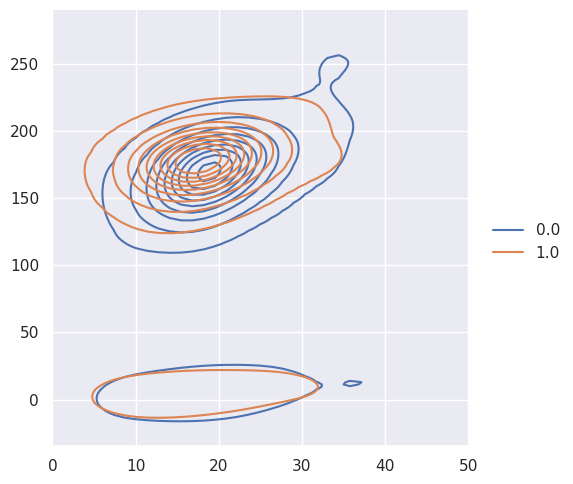

In [7]:
sns.displot(x=X[:, 0], y=X[:, 1], hue=y, kind="kde")
plt.xlim(0, 50)

In [8]:
interval_cct_reg = flowio.FlowData(
    "data/fcs_alignment/test_alignment/test_alignment_Reference_cct.fcs_Template/test_alignment_Batch_INTERVAL 36 centre_cct_rgst.fcs"
)
strides_cct_reg = flowio.FlowData(
    "data/fcs_alignment/test_alignment/test_alignment_Reference_cct.fcs_Template/test_alignment_Batch_STRIDES centre_cct_rgst.fcs"
)

In [9]:
interval_events_reg = np.array(interval_cct_reg.events)
strides_events_reg = np.array(strides_cct_reg.events)

In [10]:
# reshape to 2D array: the list of events puts all channels after each other, i.e. [SFL1, FSC1, CENSORED1, SFL2, FSC2, CENSORED2, ...]
# we want to reshape this to a 2D array where each row is an event
interval_events_reg = interval_events_reg.reshape(-1, 3)
strides_events_reg = strides_events_reg.reshape(-1, 3)

In [11]:
# let's subsample to make the arrays more manageable
interval_events_reg = interval_events_reg[interval_idx]
strides_events_reg = strides_events_reg[strides_idx]

# concatenate the two arrays and make a label array
X_reg = np.concatenate([interval_events_reg, strides_events_reg])
y_reg = np.concatenate(
    [np.zeros(len(interval_events_reg)), np.ones(len(strides_events_reg))]
)

(0.0, 50.0)

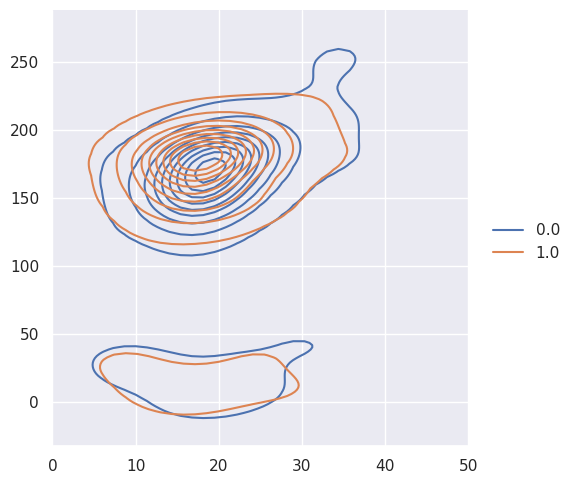

In [12]:
sns.displot(x=X_reg[:, 0], y=X_reg[:, 1], hue=y_reg, kind="kde")
plt.xlim(0, 50)

In [13]:
# concat all
X_all = np.concatenate([X, X_reg])
y_all = (
    interval_events.shape[0] * ["INTERVAL init"]
    + strides_events.shape[0] * ["STRIDES init"]
    + interval_events_reg.shape[0] * ["INTERVAL reg"]
    + strides_events_reg.shape[0] * ["STRIDES reg"]
)

(0.0, 50.0)

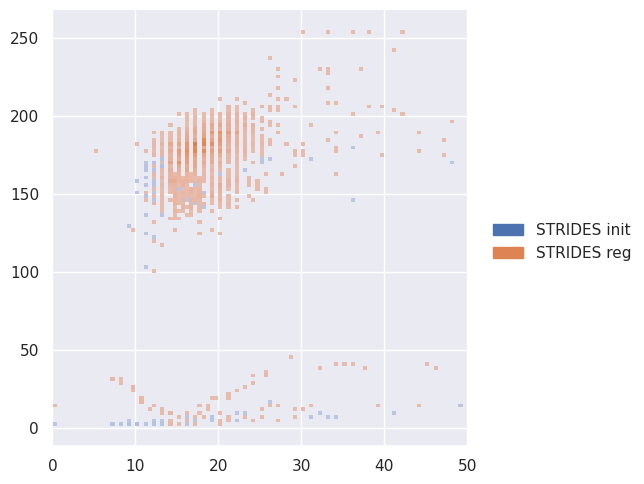

In [15]:
sns.displot(
    x=X_all[:, 0],
    y=X_all[:, 1],
    hue=y_all,
    # kind="kde",
    hue_order=[
        # "INTERVAL init",
        "STRIDES init",
        # "INTERVAL reg",
        "STRIDES reg",
    ],
)
plt.xlim(0, 50)